Notebook to generate plots to analyze the prediction model
-------------------------------------------------------------

<h4>C-Value vs Accuracy Plot:</h4>

5 => 0.760878545855
10 => 0.765629303222
15 => 0.763563756541
20 => 0.766455521895
25 => 0.764252272101
30 => 0.764871936106
35 => 0.764527678326
40 => 0.764940787662
45 => 0.764114568989
50 => 0.764114568989
100 => 0.763563756541
125 => 0.763839162765
150 => 0.764871936106
200 => 0.764389975213


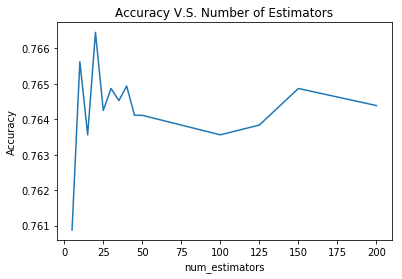

In [11]:
import sklearn 
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
from sklearn.externals import joblib


def load_data(path1,path2,path3):
	df_icu_stays = pd.read_csv(path1)
	df_sepsis_occurance = pd.read_csv(path2)
	df_events = pd.read_csv(path3)
	return df_icu_stays, df_sepsis_occurance, df_events

def join_data(df_events,df_sepsis_occurance): 
	return pd.merge(df_events, df_sepsis_occurance, on='hadm_id', how='inner')

def get_features(df_joined):
	#Creating the sparse rate feature vectors
	all_items = df_joined['itemid'].values
	all_rates = df_joined['rate'].values
	all_y = df_joined['curr_sepsis']
	item_ids = list(set(df_joined['itemid'].values)) 
	remap_items = range(len(item_ids))
	dict_items = dict(zip(item_ids,remap_items))
	item_ids = list(set(df_joined['itemid'].values)) 
	item_id_feature = np.zeros((df_joined.shape[0],len(item_ids)))
	x = []
	y = []
	for i in range(all_items.shape[0]): 
		val = all_items[i]
		rate = all_rates[i]
		remap_val = dict_items[val]
		z = np.zeros((1,len(item_ids)))[0]
		z[remap_val] = rate
		x.append(z)
		y.append(all_y[i])
	rate_feat_x = np.array(x)
	y = np.array(y)

	#Removing rows with NaNs
	nan_index = np.argwhere(np.isnan(rate_feat_x))
	nan_rows = []
	for i in nan_index: 
		nan_rows.append(i[0])
	rate_feat_x = np.delete(rate_feat_x,nan_rows,0)
	rate_feat_y = np.delete(y,nan_rows,0)
	return rate_feat_x, rate_feat_y

#Here we select our features and drop NaNs
def filter_features(df,features,pred_label):
	all_feats = features+pred_label
	new_df = df[all_feats]
	new_df = new_df.dropna(axis=0)
	new_x = new_df[features]
	new_y = new_df[pred_label]
	return new_x, new_y 

def get_random_forest_model(Rxtrain, Rytrain,est):
	seed = 7
	rf = RandomForestClassifier(n_estimators=est, max_depth= None,random_state=seed)
	rf.fit(Rxtrain, Rytrain)
	Rprediction = rf.predict(Rxtest)
	acc = accuracy_score(Rytest,Rprediction)
	return rf, acc

if __name__ == "__main__":
	seed = 7

	path1 = 'm100s2/ICUSTAYS.csv'
	path2 = 'm100s2/sample_ids_2.csv'
	path3 = 'm100s2/sample_inputevents_mv_2.csv'
	# Set Window Size
	accs = []
	hour = 5
	trees = [5,10,15,20,25,30,35,40,45,50,100,125,150,200]
	for j in range(len(trees)):

		df_icu_stays, df_sepsis_occurance, df_events = load_data(path1,path2,path3)
		df_joined = join_data(df_events, df_sepsis_occurance)

		#Convert columns to datetime objects 
		df_joined['sepsist0'] = df_joined['sepsist0'].apply(lambda i: datetime.strptime(i,'%Y-%m-%d %H:%M:%S'))
		df_joined['starttime'] = df_joined['starttime'].apply(lambda i: datetime.strptime(i,'%Y-%m-%d %H:%M:%S'))

		#Create time difference in hours column between sepsis t0 and starttime
		df_joined['time_diff'] = (df_joined['sepsist0'] - df_joined['starttime'])
		df_joined['time_diff'] = df_joined['time_diff'].apply(lambda i: i.seconds/3600)

		#1 if developed sepsis with 8 hours else 0
		df_joined['curr_sepsis'] = df_joined['time_diff'].apply(lambda i: 1 if i <= hour else 0)

		rate_feat_x, rate_feat_y = get_features(df_joined)

		Rxtrain, Rxtest, Rytrain, Rytest = train_test_split(rate_feat_x, rate_feat_y, test_size=0.20, random_state=seed)
		
		model, acc = get_random_forest_model(Rxtrain, Rytrain,trees[j])
		print (str(trees[j]) + ' => ' + str(acc))
		accs.append(acc)
	plt.plot(trees, accs)
	plt.xlabel("num_estimators")
	plt.ylabel("Accuracy")
	plt.title("Accuracy V.S. Number of Estimators")
	plt.show()

<h4>Sliding Window Hours vs Accuracy Plot:</h4>

0.5 => 0.784356926467
1 => 0.784976590471
1.5 => 0.783048746902
2 => 0.779055356651
2.5 => 0.777471770862
3 => 0.776094739741
3.5 => 0.773960341504
4 => 0.770104654365
4 => 0.770104654365
5 => 0.765629303222
5 => 0.765629303222
5.5 => 0.756678600936
6 => 0.746282015974
6.5 => 0.73781327458
7 => 0.725833103828
7.5 => 0.714610300193
8 => 0.698017075186
8.5 => 0.687345083999
9 => 0.672404296337
9.5 => 0.654502891765
10 => 0.637152299642
10.5 => 0.62255576976
11 => 0.601418342055
11.5 => 0.57938584412
12 => 0.553015698155
12.5 => 0.517625998348
13 => 0.495662351969
13.5 => 0.471357752685
14 => 0.450702285872
14.5 => 0.431148443955
15 => 0.409597906913
15.5 => 0.393142385018
16 => 0.378408152024
16.5 => 0.367116496833
17 => 0.353965849628
17.5 => 0.344257780226
18 => 0.330831726797
18.5 => 0.319264665381
19 => 0.307697603966
19.5 => 0.297438722115
20 => 0.282429082897
20.5 => 0.27175709171
21 => 0.26218672542
21.5 => 0.25364913247
22 => 0.244904984853
22.5 => 0.237882126136
23 => 0.23079041

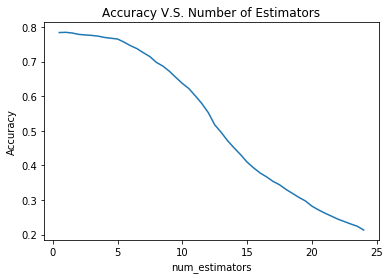

In [12]:
def plot_window():
	seed = 7

	path1 = 'm100s2/ICUSTAYS.csv'
	path2 = 'm100s2/sample_ids_2.csv'
	path3 = 'm100s2/sample_inputevents_mv_2.csv'
	# Set Window Size
	accs = []
	hours = [0.5,1,1.5,2,2.5,3,3.5,4,4,5,5,5.5,6,6.5,7,
             7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,
             13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,
            18.5,19,19.5,20,20.5,21,21.5,22,22.5,23,23.5,24]
	tree = 10
	for j in range(len(hours)):

		df_icu_stays, df_sepsis_occurance, df_events = load_data(path1,path2,path3)
		df_joined = join_data(df_events, df_sepsis_occurance)

		#Convert columns to datetime objects 
		df_joined['sepsist0'] = df_joined['sepsist0'].apply(lambda i: datetime.strptime(i,'%Y-%m-%d %H:%M:%S'))
		df_joined['starttime'] = df_joined['starttime'].apply(lambda i: datetime.strptime(i,'%Y-%m-%d %H:%M:%S'))

		#Create time difference in hours column between sepsis t0 and starttime
		df_joined['time_diff'] = (df_joined['sepsist0'] - df_joined['starttime'])
		df_joined['time_diff'] = df_joined['time_diff'].apply(lambda i: i.seconds/3600)

		#1 if developed sepsis with 8 hours else 0
		df_joined['curr_sepsis'] = df_joined['time_diff'].apply(lambda i: 1 if i <= hours[j] else 0)

		rate_feat_x, rate_feat_y = get_features(df_joined)

		Rxtrain, Rxtest, Rytrain, Rytest = train_test_split(rate_feat_x, rate_feat_y, test_size=0.20, random_state=seed)
		
		model, acc = get_random_forest_model(Rxtrain, Rytrain,tree)
		print (str(hours[j]) + ' => ' + str(acc))
		accs.append(acc)
	plt.plot(hours, accs)
	plt.xlabel("num_estimators")
	plt.ylabel("Accuracy")
	plt.title("Accuracy V.S. Number of Estimators")
	plt.show()

plot_window()